In [2]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shapely
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns

**Pest or Buda for a good beer?**

In [ ]:
# example map

In [32]:
# Budapest shape
bp_shape = gpd.read_file("../data/shape_files/budapest_shape/budapest_shape.shp")

# river shape
bp_river_shape = gpd.read_file("../data/shape_files/budapest_waters_shape/budapest_waters_shape.shp")

# districts
bp_districts = gpd.read_file("../data/shape_files/budapest_districts_shape/budapest_districts_shape.shp")

# google data on pubs with ratings

# significant difference in rating Buda / Pest?

<Axes: >

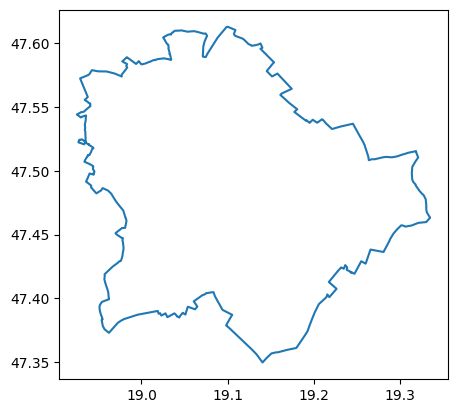

In [8]:
bp_shape.boundary.plot()

<Axes: >

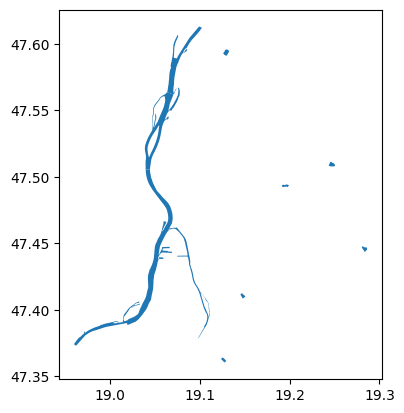

In [12]:
bp_river_shape.plot()

In [33]:
bp_districts

,name,buda01,geometry
0,XX. kerulet,0,"POLYGON ((19.09361 47.44164, 19.09373 47.44170..."
1,VII. kerulet,0,"POLYGON ((19.08019 47.51094, 19.08057 47.51112..."
2,XXII. kerulet,1,"POLYGON ((19.03455 47.43890, 19.03527 47.43784..."
3,IX. kerulet,0,"POLYGON ((19.09361 47.44164, 19.09356 47.44150..."
4,XVI. kerulet,0,"POLYGON ((19.22078 47.49255, 19.21069 47.49454..."
5,VI. kerulet,0,"POLYGON ((19.06333 47.51770, 19.06354 47.51778..."
6,IV. kerulet,0,"POLYGON ((19.10784 47.60665, 19.10863 47.60584..."
7,XIX. kerulet,0,"POLYGON ((19.15741 47.43840, 19.15811 47.43797..."
8,XV. kerulet,0,"POLYGON ((19.13811 47.59984, 19.14036 47.59640..."
9,V. kerulet,0,"POLYGON ((19.05483 47.49851, 19.05484 47.49815..."
